# Implementação de um codigo de Eigenfaces

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
<!-- Codigo para rodar Latex no Markdow -->
</script>

<s>A idea por trás dos algoritmos de eigenfaces é interpretar imagens como vetores para então aplicar conceitos de algebra linear e conseguir resultados interessantes.
No algoritmo em questão, fazemos uma matriz onde cada coluna representa uma imagem. A partir dela geramos uma matriz de covariancia, multiplicando a matriz das imagens pela sua transversa.
Dessa nova matriz, extraímos os autovalores e autovetores, e ordenamos eles conforme os autovalores mais altos, que representam o peso que aquele vetor componente possui nas descrições das imagens.</s>

A Algebra Linear possui as mais diversas aplicações, e seus conceitos estão sempre sendo utilizados de maneira criativa para obtenção dos mais variados resultados.
Nessa linha de raciocínio temos o conceito de Eigenfaces, um algoritmo para criar uma base com características principais de imagens, possibilitando escrever elas como parametros dessa base.

Assim esse trabalho irá explorar o código por trás da obtenção de Eigenfaces partindo de uma base de imagens, e sugerir aplicações para os resultados obtidos.

Iniciando o trabalho, o primeiro passo é carregar uma imagem e transforma-la em um vetor, para isso utilizaremos imagens em escala de cinza e tamanho fixo, fazendo com que o processo seja facilitado.

In [14]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import Markdown as md

Esse codigo para carregar as imagens busca elas em um diretorio de treinamente, salva os nomes dos rostos conforme a organização em pastas, e também deixa as imagens no formato que precisamos.

In [3]:
IMAGE_DIR = 'training-images'
DEFAULT_SIZE = [250, 250] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]



In [123]:
[X, nomes] = read_images()

print("Exemplo de como uma imagem está armazenada (X[0]): ")
print(X[0]);print(type(X[0]))
output = "Numero de arrays dentro desse primeiro array (tamanho de X[0]):"
output += "  <br><b>"+str(len(X[0]))+"</b><br>"
output += "Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):"
output += "  <br><b>"+str(len(X[0][0]))+ "</b>"
output += "<br>"+"Ou seja, cada imagem está armazenada como uma lista com "+str(len(X[0]))+" 'linhas', onde cada linha tem "+str(len(X[0][0]))+" entradas, cada uma correspondente a um pixel da imagem. <br>"
md(output)

Exemplo de como uma imagem está armazenada (X[0]): 
[[  0   0   0 ...   1   1   1]
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   3   3   3]
 ...
 [119 125 133 ... 130 143 150]
 [118 120 127 ... 137 150 157]
 [114 116 123 ... 143 154 161]]
<class 'numpy.ndarray'>


Numero de arrays dentro desse primeiro array (tamanho de X[0]):  <br><b>250</b><br>Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):  <br><b>250</b><br>Ou seja, cada imagem está armazenada como uma lista com 250 'linhas', onde cada linha tem 250 entradas, cada uma correspondente a um pixel da imagem. <br>

Essas imagens são as que estão na pasta de imagens de treinamento, aqui está uma amostra:

In [124]:
# Função para plotar as imagens
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10), just_sample=False):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )


total face-count:  53


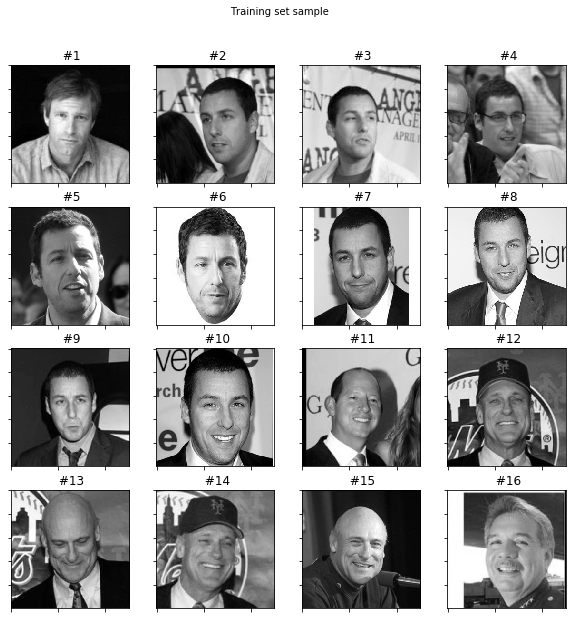

In [125]:
E = []
number = len(X)
for i in range (min(number, 16)):
    E.append(np.asarray(X[i]))
subplot ( title ="Training set sample", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="sample-of-initial-faces.png")
print("total face-count: ",number)

Agora para prosseguir com os calculos precisamos que cada imagem seja um vetor de valores reais, e não uma lista de listas, para isso, as informações dos valores de cada pixel serão ordenados e transformados em um vetor com 250x250=62500 entradas, como ilustra essa imagem do processo de "flattening", ou achatamento:
![Imagem de uma matriz m por n se transformando em um vetor n vezes m por 1](https://images.squarespace-cdn.com/content/v1/5d9292fac5e43353ecec826f/1577637417039-UCB6LZG39YHOMQZB0VMM/fig11.png?format=1500w)
<p style="font-size:8px; color:#bbb">Ilustração retirada de <a style="font-size:8px; color:#bbb">https://www.mccallum-pda.com/mpda-blog/part-2-mineral-model-optimization-using-a-genetic-algorithm</a> encontrada pelo mecanismo de busca do google.</p>

In [126]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1)))
    return mat

In [127]:
images_as_rows = as_row_matrix(X)
print("Shape da matriz (colunas = imagens, linhas = pixels da imagem)")
images_as_rows.shape

Shape da matriz (colunas = imagens, linhas = pixels da imagem)


(53, 62500)

Temos então $ X= \begin{bmatrix}F_1 & F_2 & ... & F_k \end{bmatrix} $
Com cada face $F_i$ sendo $F_{px1}$ e $p$ sendo o nosso numero de pixels por imagem. ($k$ é o nosso numero de imagens de faces.)

Agora que cada imagem é um vetor, é possivel realizar operações entre vetores e exibir um vetor como uma imagem, um exemplo disso é o vetor médio $\mu$, ou a face média, obtida pela media dos vetores:

$\mu = \frac{1}{n}\sum_{i=1}^{n} F_i $

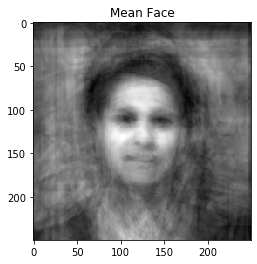

In [43]:
average_weight = np.reshape(images_as_rows.mean(axis =0), DEFAULT_SIZE)
plt.imshow(average_weight, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

Para prosseguir com o procedimento de busca pelas eigenfaces, o proximo passo é subtrair esse vetor "mean face" das imagens de faces, para termos então o que cada face específica acrescenta de caracteristica nova à face media.
Teremos então  $\phi_i = F_i - \mu$ 

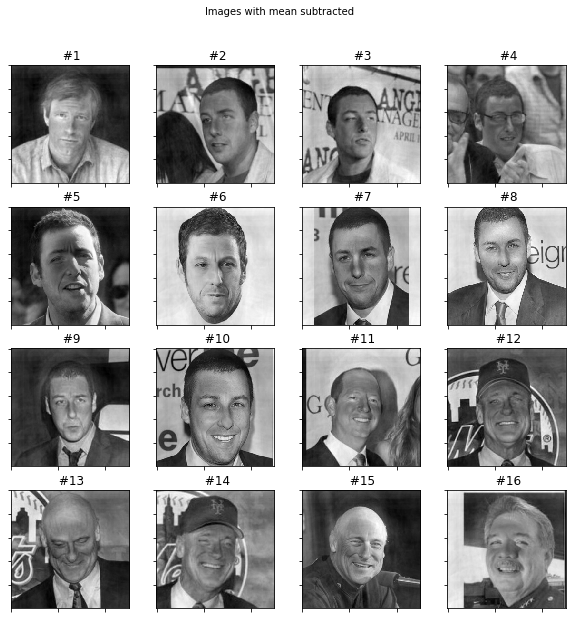

In [49]:
E = []
img_x = X
number = len(img_x)
for i in range (min(number, 16)):
    E.append(np.asarray(img_x[i]-average_weight))
subplot ( title ="Images with mean subtracted", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="images-subtracted-mean.png")

In [44]:
X = images_as_rows
mu = X.mean(axis =0)
phi = X - mu
[n,m] = phi.shape

<s>A partir dessa matriz $\phi$ vamos montar uma matriz de covariancia $C$, em que reza lenda $C=\phi \phi^T$, e encontrar os autovalores e autovetores dela. Com isso, teremos, pela logica do funcionamento dos autovetores, todo um rolê de PCA aqui que eu não sei nada, e com isso nos sabemos que podemos retirar os autovetores com valores mais altos pois eles possuem maior influencia nas caracteristicas das imagens, e portanto eles são nossas eigenfaces </s>

A partir de $\phi$, montamos uma matriz de Covariancia $C=\phi \phi^T$, que expressa a correlação entre as imagens.<br>
Como $C$ é simétrica (sua simetria fica explicita na sua obtenção mostrada acima), então, pelo teoremo espectral:<br>
TExto daora de ajuda: <br>
$C = Q\Lambda Q^{T}$ =  $\sum \lambda_{i} q_{i}q_{i}^{T}$, 
em que $q_{i}$ é o autovetor de $C$ correspondent ao autovalor $\lambda_{i}$; isto é, $C$ é uma soma ponderada pelos seus autovalores de matrizes da forma $vv^{T}$. o objetivo do eigenfaces é, eu presumo, escolher os termos que mais modificam esta soma: os autovetores correspondentes aos maiores autovalores

In [46]:
if n>m: # Condição para executar o codigo mais rapido. (devido ao custo de calcular phi * phi^T, isso é contornado dessa forma, tirando proveito de que os autovalores da transposta são os mesmos:)
    C = np.dot(phi.T,phi) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = eigenvectors.T
else :
    C = np.dot (phi,phi.T) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = np.dot(phi.T, eigenvectors )
    for i in range (n):
        eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    eigenvectors = eigenvectors.T

In [82]:
def fmt(value):
    value = round(value, 2)
    return str(value)

m1=fmt(eigenvalues[0])+r" & 0 & ... & 0 \\ "
m2=" 0 & "+fmt(eigenvalues[1])+r" & ... & 0 \\"
m3=r" ... & ... & ... & ... \\ "
m4=r" 0 & 0 & ... & "+fmt(eigenvalues[-1])
output=r"$\Lambda = \begin{bmatrix}"+m1+m2+m3+m4+r"\end{bmatrix}$"
md(output)

$\Lambda = \begin{bmatrix}5059122407.82 & 0 & ... & 0 \\  0 & 2005959495.6 & ... & 0 \\ ... & ... & ... & ... \\  0 & 0 & ... & -0.0\end{bmatrix}$

In [80]:
def bvec(vector):
    vecc = r"\begin{bmatrix}"
    vecc += str(round(vector[0],5)) + r"\\"
    vecc += str(round(vector[1],5)) + r"\\"
    vecc += r"..." + r"\\"
    vecc += str(round(vector[-1],5))
    vecc += r"\end{bmatrix}"
    return vecc

output = r"$Q$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q$=$\begin{bmatrix}\begin{bmatrix}-0.00633\\-0.00624\\...\\-0.00317\end{bmatrix} & \begin{bmatrix}-0.00455\\-0.00461\\...\\-0.00421\end{bmatrix} & ... & \begin{bmatrix}-0.00081\\-0.00163\\...\\-0.00328\end{bmatrix}\end{bmatrix}$

Ordenamos agora os autovalores em ordem decrescente, para que nossas matrizes iniciem com os autovalores e autovetores respectivos que possuam maior influencia no valor final da multiplicação.

In [85]:
ordered_index = np.argsort (- eigenvalues )
eigenvalues = eigenvalues [ordered_index] # O autovalor i se torna o elemento de indice i conforme lista de indices ordenados
eigenvectors = eigenvectors [ordered_index] # O autovetor i se torna o vetor de indice i conforme lista de indices ordenados

In [86]:
output = r" $ \Lambda = \begin{bmatrix}"+fmt(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+fmt(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+fmt(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)


 $ \Lambda = \begin{bmatrix}5059122407.82 & 0 & ... & 0 \\ 0 & 2005959495.6 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &-0.0 \end{bmatrix}$

In [87]:
output = r"$Q$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q$=$\begin{bmatrix}\begin{bmatrix}-0.00633\\-0.00624\\...\\-0.00317\end{bmatrix} & \begin{bmatrix}-0.00455\\-0.00461\\...\\-0.00421\end{bmatrix} & ... & \begin{bmatrix}-0.00081\\-0.00163\\...\\-0.00328\end{bmatrix}\end{bmatrix}$

Agora, como os valores do final possuem pouca influencia no valor final, podemos descartar parte deles para matermos apenas os componentes principais.

Aqui da pra ver a influencia deles, se eu entendi certo o algoritmo

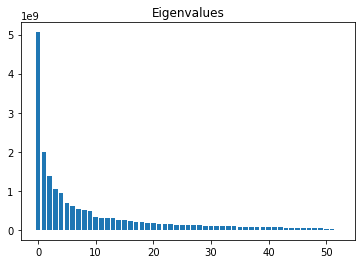

In [98]:
plt.figure()
plt.title('Eigenvalues')
plt.bar(range(eigenvalues.shape[0]), eigenvalues)
plt.show()

In [99]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

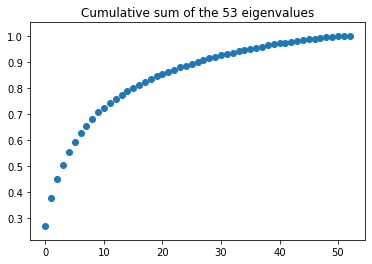

In [100]:
plot_eigen_value_distribution(eigenvalues, range(0, eigenvalues.shape[0]))
plt.title("Cumulative sum of the {0} eigenvalues".format(eigenvalues.shape[0]))
plt.show()

Esse grafico ta horrivel de entender, mas nos ultimos alí, tem pouca diferença de um pro outro, então eles não acrescentam nada e <b style="font-weight:900;color: darkred">DEVEM SER ELIMINADOS</b>

Pra ver quantos autovetores, meio q pode ser um numero arbitrário, mas eu roubei esse codigo aqui:

In [102]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii

In [109]:
num_components = get_number_of_components_to_preserve_variance(eigenvalues)
print("estamos selecionando ",num_components," de ",eigenvalues.shape[0]," autovetores")
print("para mais precisão, fazendo a soma cumulativa chegar a 98%, poderiamos selecionar",get_number_of_components_to_preserve_variance(eigenvalues,.98),", ou diminuir o detalhe para 90%, nesse caso seriam ",get_number_of_components_to_preserve_variance(eigenvalues,.90))

estamos selecionando  35  de  53  autovetores
para mais precisão, fazendo a soma cumulativa chegar a 98%, poderiamos selecionar 43 , ou diminuir o detalhe para 90%, nesse caso seriam  26


E agora temos nossa versão reduzida:

In [130]:
eigenvalues = eigenvalues [0: num_components ].copy ()
eigenvectors = eigenvectors [0: num_components ].copy ()

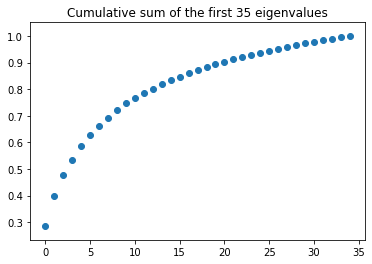

In [64]:
plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()

In [122]:
output = r" $\Lambda \to \Lambda_{principais} = \begin{bmatrix}"+str(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+str(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+str(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)

 $\Lambda \to \Lambda_{principais} = \begin{bmatrix}5059122407.823185 & 0 & ... & 0 \\ 0 & 2005959495.6029186 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &90544233.53341874 \end{bmatrix}$

In [120]:
output = r"$Q \to W$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q \to W$=$\begin{bmatrix}\begin{bmatrix}-0.00633\\-0.00624\\...\\-0.00317\end{bmatrix} & \begin{bmatrix}-0.00455\\-0.00461\\...\\-0.00421\end{bmatrix} & ... & \begin{bmatrix}-0.00886\\-0.00891\\...\\-0.00261\end{bmatrix}\end{bmatrix}$

E podemos visualizar a conversão de vetor para imagem de alguns dos nossos autovetores, ou eigenfaces.

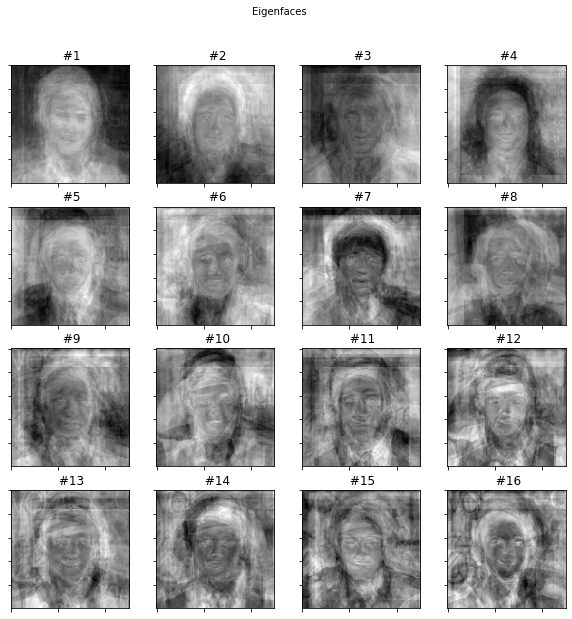

In [117]:
E = []
number = eigenvectors.shape[0]
for i in range (min(number, 16)):
    e = eigenvectors[i].reshape(DEFAULT_SIZE)
    E.append(np.asarray(e))
    
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

Agora que conseguimos as eigenfaces, temos uma base que podemos utilizar para representar cada face.
Cada face $F$ passará a ser escrita como $F-\mu=\alpha_1 x_1 + \alpha_2 x_2+ ... + \alpha_k x_k $, com cada $x_i$ sendo uma eigenface e cada $\alpha_i$ sendo um valor real ($\mu$ é a face média), basta apenas "projetar" cada face nesse espaço para escrever elas como uma combinação linear das eigenfaces... Dessa forma, para cada face, não salvamos todos os valores de seus pixels, apenas os valores dos $\alpha$'s que multiplicam nossa base. Então:
$F = Wy + \mu$, onde $W$ é a matriz com nossas eigenfaces e $y$ são nossos $\alpha$'s.

Já possuímos $W$ e $\mu$, no primeiro caso, quando queremos projetar, $F$ é a face que projetaremos e buscamos $y$, a partir da formula acima: <br>
$y = W^{-1}(F - \mu) $

In [118]:
def project (W , X , mu):
    return np.dot (X - mu , W.T)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W) + mu

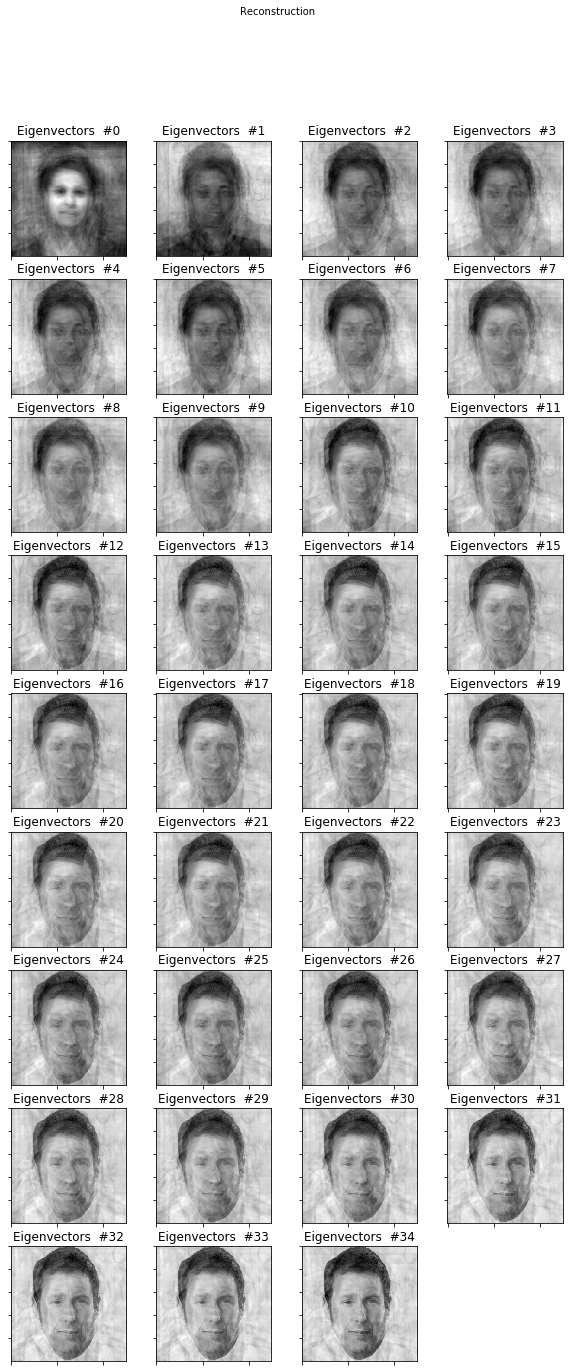

In [108]:
steps =[i for i in range (eigenvectors.shape[0])]
E = []
img_to_reconstruct = X[5] #Expecting a vector img
for i in range (len(steps)):
    numEvs = steps[i]
    P = project(eigenvectors[0: numEvs], img_to_reconstruct , mu)
    R = reconstruct(eigenvectors[0: numEvs], P, mu)
    # reshape and append to plots
    R = R.reshape(DEFAULT_SIZE)
    E.append(np.asarray(R))
subplot ( title ="Reconstruction", images =E, rows =10, cols =4, 
         sptitle ="Eigenvectors ", sptitles =steps , colormap =plt.cm.gray , filename ="python_pca_reconstruction.png",figsize = (10, 25))

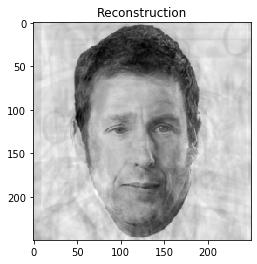

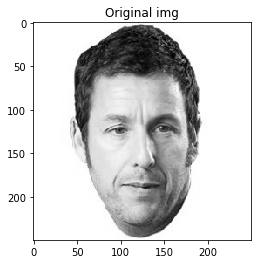

In [109]:
P = project(eigenvectors[0: -1], img_to_reconstruct , mu)
R = reconstruct(eigenvectors[0: -1], P, mu)
R = R

reconstruction = np.reshape(R, DEFAULT_SIZE)
plt.imshow(reconstruction, cmap=plt.cm.gray)
plt.title("Reconstruction")
plt.show()
original_img = np.reshape(img_to_reconstruct, DEFAULT_SIZE)
plt.imshow(original_img, cmap=plt.cm.gray)
plt.title("Original img")
plt.show()


Parte onde pretendo colocar um pouco de "reconhecimento facil": projetar todas as imagens originais na base de autovetores e tirar a distancia entre a imagem nova e essas. A com menor distancia é a mais parecida.

A ideia é ilustrar as funções com Latex, no mesmo estilo de como fiz pra cima, nas de cima tentarei colocar mais um detalhe ou outro de Latex tbm.

In [110]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

In [111]:
def predict (W, mu , projections, y, img_to_predict):
    minDist = float("inf")
    minClass = -1
    Q = project (W, img_to_predict, mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

WIP

In [114]:
# projections = []
# for xi in X:
#     projections.append(project (eigenvectors, xi , mu))

# image = Image.open("test2.jpg")
# image = image.convert ("L")
# if (DEFAULT_SIZE is not None ):
#     image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
# test_image = np. asarray (image , dtype =np. uint8 )
# test_image.reshape()
# predicted = predict(eigenvectors, mu , projections, y, test_image)

# subplot ( title ="Prediction", images =[test_image, X[predicted]], rows =1, cols =2, 
#          sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
#          filename ="prediction_test.png", figsize = (5,5))